In [2]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics
import string
import spacy
from spacy.lang.en import English
import pandas as pd
import numpy as np
import re

In [3]:
def url_search(text):
    list1 = []
    m = re.search('https?://([A-Za-z_0-9.-]+).*', text)
    if m:
        return (m.group(1))

In [4]:
! ls /data/dssg-disinfo/

articles_tokenized_v3.csv  full.csv		  negative_articles_v3.csv
articles_v3.csv		   glove.6B.300d.txt	  positive_articles.csv
covid_news_data.jsonl	   glove.tgz		  positive_articles_v3.csv
df_pos.csv		   nano.save		  uw_data1.csv
df_sent.csv		   negative_articles.csv  word-embeddings


In [5]:
df = pd.read_csv('/data/dssg-disinfo/articles_v3.csv')

In [6]:
df_p = pd.read_csv('/data/dssg-disinfo/positive_articles.csv')

In [7]:
df_p['urls'] = [url_search(m) for m in df_p['article_text']]

In [8]:
df_p.groupby(['domain_name', 'urls'])[['article_pk']].count()

article_pk
domain_name             urls                                  
21stcenturywire.com     t.co                                 2
                        www.cdc.gov                          3
                        www.england.nhs.uk                   2
                        www.nejm.org                         2
aanirfan.blogspot.co.uk aanirfan.blogspot.co.                1
...                                                        ...
wakingtimes.com         www.thenewhumanitarian.org           1
westernjournal.com      t.co                                18
worldtruth.tv           t.co                                 3
zerohedge.com           t.co                                39
                        www.the-scientist.com                1

[495 rows x 1 columns]

In [9]:
df_p[~(df_p['urls']==None)]

,article_pk,domain_pk,domain_name,article_url,label,article_headline,article_text,urls
0,46858240,3922,westernjournal.com,https://www.westernjournal.com/first-four-fact...,1,Gretchen Whitmer: First Four Facts You Need To...,Democratic Gov. Gretchen Whitmer has made quit...,t.co
1,38076419,51,aanirfan.blogspot.co.uk,http://aanirfan.blogspot.com/2020/05/randolph-...,1,NaN,"Aangirfan\nFriday, 1 May 2020\nRANDOLPH STEWAR...",en.wikipedia.org
2,36831236,4034,centerforsecuritypolicy.org,https://www.centerforsecuritypolicy.org/2020/0...,1,Rewarding the CCP for its pandemic MUST NOT HA...,Senator Tom Cotton believes the Chinese Commun...,None
3,47480838,3851,thenewamerican.com,http://www.thenewamerican.com/culture/faith-an...,1,Catholic Bishops: COVID-19 Measures Are “Prelu...,A document titled “Appeal for the Church and t...,None
4,50200584,460,prisonplanet.com,https://www.prisonplanet.com/?p=320847,1,Coronavirus ‘Cover-Up’ Is China’s Chernobyl: W...,“It was a cover-up. And we’ll get to the botto...,None
...,...,...,...,...,...,...,...,...
12542,37093363,4206,https://www.conservapedia.com,https://www.conservapedia.com/2016_Presidentia...,1,"United States presidential election, 2016",From Conservapedia\n\n2016 election results\n\...,None
12543,37093366,4206,https://www.conservapedia.com,https://www.conservapedia.com/Ukrainian_collus...,1,Ukrainian collusion,From Conservapedia\n\nSee also Spygate\n\n[1] ...,www.politifact.com
12544,39026680,611,veteranstoday.com,https://www.veteranstoday.com/2020/05/02/break...,1,Breaking: China calls for closing all US biolo...,AE.Daily: The Chinese authorities support the ...,t.co
12545,47316986,1164,pajamasmedia.com,https://pjmedia.com/columns/stephen-kruiser/20...,1,The Morning Briefing: Censorship Has Mutated a...,"Censorship, Pandemic Style\n\nCensorship is un...",t.co


In [10]:
df_sent = pd.read_csv('/data/dssg-disinfo/df_sent.csv')

In [11]:
df_sent.drop(columns=['Unnamed: 0'], inplace=True)

In [12]:
df_sent

,article_pk,label,sentences,sent_count
0,67608582,1,['MAD AS HELL EMBD_HTML Search Search for: COM...,4
1,67043336,1,['An FBI investigation has revealed NASCAR rac...,31
2,67043343,1,['The View co-host Joy Behar admitted coronavi...,14
3,70303763,1,['Actor Sacha Baron Cohen infiltrated a pro-gu...,14
4,69337110,1,"['Posted on by martyrashrakat June 26, 2020 ...",91
...,...,...,...,...
28408,7955415,0,"[""ITV Search news Main page content Advertisem...",11
28409,7756953,0,"[""men Load mobile navigation My Account Subscr...",6
28410,7756941,0,"[""men Load mobile navigation My Account Subscr...",9
28411,7756936,0,"[""men Load mobile navigation My Account Subscr...",6


In [13]:
df_with_sent = pd.concat([df.drop(columns=['label', 'article_pk']), df_sent], axis=1)

In [14]:
df_with_sent.head(1)

,domain_pk,domain_name,article_url,article_headline,article_text,publish_date,article_pk,label,sentences,sent_count
0,4004,madashellnews.com,http://madashellnews.com/?p=18792,NaN,MAD AS HELL EMBD_HTML Search Search for: COMMU...,2020-06-25T09:58:17.293Z,67608582,1,['MAD AS HELL EMBD_HTML Search Search for: COM...,4


(array([2.6996e+04, 9.4600e+02, 2.7400e+02, 9.1000e+01, 4.9000e+01,
        2.5000e+01, 9.0000e+00, 1.1000e+01, 0.0000e+00, 1.2000e+01]),
 array([1.0000e+00, 1.2650e+02, 2.5200e+02, 3.7750e+02, 5.0300e+02,
        6.2850e+02, 7.5400e+02, 8.7950e+02, 1.0050e+03, 1.1305e+03,
        1.2560e+03]),
 <a list of 10 Patch objects>)

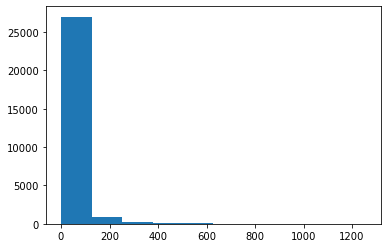

In [15]:
plt.hist(df_with_sent['sent_count'] )

In [94]:
df_with_sent['token_count'].describe()

count    28413.000000
mean       587.411361
std       1115.214962
min          4.000000
25%        225.000000
50%        367.000000
75%        591.000000
max      39718.000000
Name: token_count, dtype: float64

In [ ]:
plt.hist(filtered_df['token_count'] )
plt.xlim(left=100)

In [ ]:
#filtered_df = df_with_sent[(df_with_sent['sent_count'] < 400) & (df_with_sent['sent_count'] > 10)]

In [23]:
# this is the customized tokenizer for Vectorizer function

# Create our list of punctuation marks
punctuations = string.punctuation
# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in punctuations]
    # return preprocessed list of tokens
    return mytokens

# Tokenizer for removing stopwords
def spacy_tokenizer_remove_stopwords(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    # Removing stop words
    mytokens = [ word.lower_ for word in mytokens]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens


In [24]:
df_with_sent['tokens'] = df_with_sent['article_text'].apply(lambda x: spacy_tokenizer_remove_stopwords(x))

In [25]:
df_with_sent['token_count'] = [len(x) for x in df_with_sent['tokens']]

In [28]:
df_with_sent['tok_sent'] = df_with_sent['token_count']/df_with_sent['sent_count']

In [29]:
df_with_sent.sort_values(by='tok_sent', ascending=False)

,domain_pk,domain_name,article_url,article_headline,article_text,publish_date,article_pk,label,sentences,sent_count,tokens,token_count,tok_sent
2226,117,breitbart.com,https://www.breitbart.com/news,NaN,Skip to content BREITBART Politics Entertainme...,2020-04-22T01:08:20.056Z,7998964,1,"[""Skip to content BREITBART Politics Entertain...",1,"[skip, content, breitbart, politics, entertain...",1095,1095.000000
4677,117,breitbart.com,https://www.breitbart.com/news/topic/us/,NaN,Skip to content BREITBART Politics Entertainme...,2020-04-22T01:08:10.235Z,4535030,1,"[""Skip to content BREITBART Politics Entertain...",1,"[skip, content, breitbart, politics, entertain...",1049,1049.000000
1399,117,breitbart.com,https://www.breitbart.com/news/,NaN,Skip to content BREITBART Politics Entertainme...,2020-04-22T01:07:14.574Z,7963003,1,"[""Skip to content BREITBART Politics Entertain...",1,"[skip, content, breitbart, politics, entertain...",938,938.000000
4704,117,breitbart.com,https://www.breitbart.com/news/page/2/,NaN,Skip to content BREITBART Politics Entertainme...,2020-04-22T01:08:28.649Z,4535082,1,"[""Skip to content BREITBART Politics Entertain...",1,"[skip, content, breitbart, politics, entertain...",919,919.000000
4680,117,breitbart.com,https://www.breitbart.com/news/source/breitbar...,NaN,Skip to content BREITBART Politics Entertainme...,2020-04-22T01:07:56.459Z,4535033,1,"[""Skip to content BREITBART Politics Entertain...",1,"[skip, content, breitbart, politics, entertain...",817,817.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,163,counterinformation.wordpress.com,https://envirowatchrangitikei.wordpress.com/20...,NaN,Don't have Telegram yet? Try it now! EMBD_HTML...,2020-06-24T10:02:33.600Z,67164288,1,"[""Don't have Telegram yet?"", 'Try it now!', ""E...",3,"[telegram, try, embd_html, hear, md, expose, b...",10,3.333333
16174,1788,www.bbc.co.uk,https://www.bbc.co.uk/sounds/play/p08ffjgq,Woman's Hour - How are cleaners being treated ...,How are cleaners being treated during COVID? H...,2020-05-29T14:02:11.199Z,51656748,0,['How are cleaners being treated during COVID?...,2,"[cleaners, treated, covid, cleaners, treated, ...",6,3.000000
8859,163,counterinformation.wordpress.com,https://envirowatchrangitikei.wordpress.com/20...,NaN,Don't have Telegram yet? Try it now! EMBD_HTML...,2020-05-23T22:05:24.298Z,49214200,1,"[""Don't have Telegram yet?"", 'Try it now!', 'E...",3,"[telegram, try, embd_html, roads, closed, cali...",9,3.000000
33,297,humansarefree.com,https://humansarefree.com/2020/06/did-bill-gat...,Did Bill Gates Disappear? Whats He Been Up to ...,Did Bill Gates disappear? Whats he been up to ...,2020-06-22T00:00:00Z,66494710,1,"['Did Bill Gates disappear?', 'Whats he been u...",4,"[bill, gates, disappear, s, months, , discuss...",11,2.750000


(array([2.8197e+04, 1.0900e+02, 4.4000e+01, 3.7000e+01, 8.0000e+00,
        1.0000e+01, 3.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([   2.25 ,  111.525,  220.8  ,  330.075,  439.35 ,  548.625,
         657.9  ,  767.175,  876.45 ,  985.725, 1095.   ]),
 <a list of 10 Patch objects>)

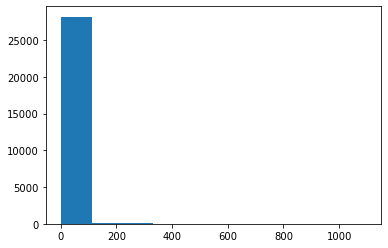

In [30]:
plt.hist(df_with_sent['tok_sent'])

In [31]:
df_with_sent[df_with_sent['article_pk'] == 67608582].article_url

0    http://madashellnews.com/?p=18792
Name: article_url, dtype: object

(array([2.8096e+04, 2.3500e+02, 7.0000e+01, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1000e+01]),
 array([4.00000e+00, 3.97540e+03, 7.94680e+03, 1.19182e+04, 1.58896e+04,
        1.98610e+04, 2.38324e+04, 2.78038e+04, 3.17752e+04, 3.57466e+04,
        3.97180e+04]),
 <a list of 10 Patch objects>)

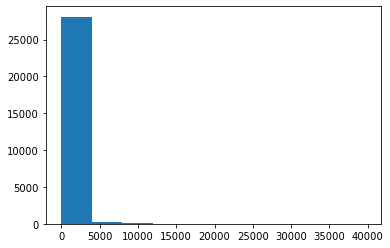

In [32]:
plt.hist(df_with_sent['token_count'])

In [ ]:
#filtered_data = filtered_df[(filtered_df['tok_sent'] < 30) & (filtered_df['token_count']< 638)]

In [33]:
df_with_sent.sort_values(by='sent_count')

,domain_pk,domain_name,article_url,article_headline,article_text,publish_date,article_pk,label,sentences,sent_count,tokens,token_count,tok_sent
3199,37651,https://www.theepochtimes.com,https://www.theepochtimes.com/live-chinese-cit...,LIVE: Chinese City: Armed Police Patrolling 24/7,FDA Allows Emergency Use of Remdesivir to Trea...,2020-05-02T00:42:01Z,38476980,1,['FDA Allows Emergency Use of Remdesivir to Tr...,1,"[fda, allows, emergency, use, remdesivir, trea...",11,11.000000
2432,163,counterinformation.wordpress.com,https://envirowatchrangitikei.wordpress.com/20...,Telegram: Share Web Page,EMBD_HTML Drs Rashid Buttar & Judy Mikovits -...,2020-05-05T00:00:00Z,40800712,1,"[""EMBD_HTML Drs Rashid Buttar & Judy Mikovits...",1,"[embd_html, , drs, rashid, buttar, judy, miko...",13,13.000000
2435,37651,https://www.theepochtimes.com,https://www.theepochtimes.com/edition/china-in...,NaN,Premium Editions Mind & Body Life & Tradition ...,2020-05-06T14:13:20.470Z,41423315,1,['Premium Editions Mind & Body Life & Traditio...,1,"[premium, editions, mind, body, life, traditio...",106,106.000000
412,25926,https://www.timesnownews.com,https://www.timesnownews.com/videos/tv-news/in...,NaN,Times Now Follow us on : BUSINESS Tax Calculat...,2020-06-20T10:51:19.768Z,64932908,1,"[""Times Now Follow us on : BUSINESS Tax Calcul...",1,"[times, follow, business, tax, calculator, eco...",296,296.000000
25978,1705,www.theguardian.com,https://www.theguardian.com/world/gallery/2020...,Social distance cinema: drive-in theatres boom...,With the widespread closures of cinemas as par...,2020-05-05T00:00:00Z,40810316,0,['With the widespread closures of cinemas as p...,1,"[widespread, closures, cinemas, measures, stem...",18,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10090,11,economist.com,http://marketingsolutions.economist.com/contac...,NaN,Skip to main content Contact Us Toggle navigat...,2020-04-23T08:36:04.764Z,7977492,0,['Skip to main content Contact Us Toggle navig...,1248,"[skip, main, content, contact, toggle, navigat...",39718,31.825321
10085,11,economist.com,https://thoughtthatcounts.economist.com/curren...,NaN,Skip to main content Toggle navigation Search ...,2020-04-23T22:11:52.677Z,8320575,0,['Skip to main content Toggle navigation Searc...,1252,"[skip, main, content, toggle, navigation, sear...",39643,31.663738
10053,11,economist.com,https://thoughtthatcounts.economist.com/sites/...,NaN,Skip to main content Toggle navigation Search ...,2020-06-03T14:22:44.701Z,54327559,0,['Skip to main content Toggle navigation Searc...,1256,"[skip, main, content, toggle, navigation, sear...",39666,31.581210
10084,11,economist.com,https://thoughtthatcounts.economist.com/sites/...,NaN,Skip to main content Toggle navigation Search ...,2020-04-25T12:35:35.105Z,8320601,0,['Skip to main content Toggle navigation Searc...,1256,"[skip, main, content, toggle, navigation, sear...",39664,31.579618


(array([2.8197e+04, 1.0900e+02, 4.4000e+01, 3.7000e+01, 8.0000e+00,
        1.0000e+01, 3.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([   2.25 ,  111.525,  220.8  ,  330.075,  439.35 ,  548.625,
         657.9  ,  767.175,  876.45 ,  985.725, 1095.   ]),
 <a list of 10 Patch objects>)

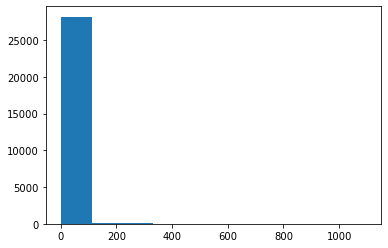

In [34]:
plt.hist(df_with_sent['tok_sent'])

(array([2.6996e+04, 9.4600e+02, 2.7400e+02, 9.1000e+01, 4.9000e+01,
        2.5000e+01, 9.0000e+00, 1.1000e+01, 0.0000e+00, 1.2000e+01]),
 array([1.0000e+00, 1.2650e+02, 2.5200e+02, 3.7750e+02, 5.0300e+02,
        6.2850e+02, 7.5400e+02, 8.7950e+02, 1.0050e+03, 1.1305e+03,
        1.2560e+03]),
 <a list of 10 Patch objects>)

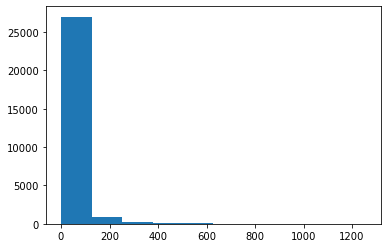

In [35]:
plt.hist(df_with_sent['sent_count'])

(array([2.8096e+04, 2.3500e+02, 7.0000e+01, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1000e+01]),
 array([4.00000e+00, 3.97540e+03, 7.94680e+03, 1.19182e+04, 1.58896e+04,
        1.98610e+04, 2.38324e+04, 2.78038e+04, 3.17752e+04, 3.57466e+04,
        3.97180e+04]),
 <a list of 10 Patch objects>)

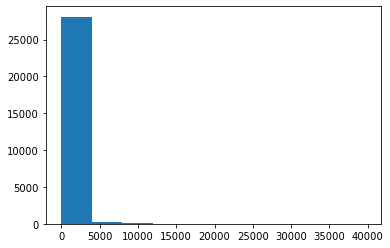

In [36]:
plt.hist(df_with_sent['token_count'])

In [71]:
df_with_sent.head(1)

,domain_pk,domain_name,article_url,article_headline,article_text,publish_date,article_pk,label,sentences,sent_count,tokens,token_count,tok_sent
0,4004,madashellnews.com,http://madashellnews.com/?p=18792,NaN,MAD AS HELL EMBD_HTML Search Search for: COMMU...,2020-06-25T09:58:17.293Z,67608582,1,['MAD AS HELL EMBD_HTML Search Search for: COM...,4,"[mad, hell, embd_html, search, search, communi...",1105,276.25


LOGISTIC REGRESSION WITH TOKEN COUNT ONLY~

In [106]:
x = df_with_sent['token_count']
y = df_with_sent['label']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, test_size=0.3)

In [114]:
X_train.shape, y_train.shape, X_test.shape

((19889,), (19889,), (8524,))

In [115]:
X_train.values.reshape(-1,1)

array([[ 33],
       [999],
       [709],
       ...,
       [425],
       [432],
       [ 58]])

In [116]:
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)
#y_train = y_train.values.reshape(-1,1)

In [117]:

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [118]:
# Model Accuracy TOKENS ONLY
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predictions))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predictions))

Logistic Regression Accuracy: 0.6920459877991553
Logistic Regression Precision: 0.7
Logistic Regression Recall: 0.16211545108883513


In [ ]:
# filtering data to 900 tokens

In [101]:
df_700_30 = df_with_sent[(df_with_sent['token_count']<901) & (df_with_sent['tok_sent']<30)]

In [102]:
df_700_30.describe()

,domain_pk,article_pk,label,sent_count,token_count,tok_sent
count,23966.000000,2.396600e+04,23966.000000,23966.000000,23966.000000,23966.000000
mean,4880.277602,4.809036e+07,0.290203,27.173245,346.415464,13.651364
std,9501.017324,1.115877e+07,0.453865,17.989654,197.137594,3.481871
min,8.000000,5.214000e+03,0.000000,1.000000,4.000000,2.250000
25%,1623.000000,3.996386e+07,0.000000,14.000000,201.000000,11.272727
50%,1705.000000,4.620788e+07,0.000000,23.000000,322.000000,13.423660
75%,1826.000000,5.509689e+07,1.000000,37.000000,474.000000,15.625000
max,70537.000000,7.145287e+07,1.000000,147.000000,900.000000,29.952381


In [104]:
# Create pipeline using Bag of Words

X_train, X_test, y_train, y_test = train_test_split(df_700_30.article_text, df_700_30.label, random_state = 42)

pipe = Pipeline([('vectorizer', CountVectorizer(tokenizer=spacy_tokenizer,ngram_range=(1,1))),
                 ('classifier', LogisticRegression(max_iter = 200)
)])

# model generation
pipe.fit(X_train1,y_train1)

# Predicting with a test dataset
predicted1 = pipe.predict(X_test1)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test1, predicted1))
print("Logistic Regression Precision:",metrics.precision_score(y_test1, predicted1))
print("Logistic Regression Recall:",metrics.recall_score(y_test1, predicted1))

# Get predicted probabilities
y_score1 = pipe.predict_proba(X_test1)[:,1]

# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test1, y_score1)

print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test1, y_score1))

# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression (Count Vectorizer)')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

AttributeError: 'int' object has no attribute 'lower'

In [ ]:
# Create pipeline using Bag of Words
pipe_tfidf = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer,ngram_range=(1,1))),
                 ('classifier', LogisticRegression(max_iter = 200)
)])

# model generation
pipe_tfidf.fit(X_train1,y_train1)

# Predicting with a test dataset
predicted2 = pipe_tfidf.predict(X_test1)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test1, predicted2))
print("Logistic Regression Precision:",metrics.precision_score(y_test1, predicted2))
print("Logistic Regression Recall:",metrics.recall_score(y_test1, predicted2))

# Get predicted probabilities
y_score2 = pipe_tfidf.predict_proba(X_test1)[:,1]

# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test1, y_score2)

print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test1, y_score2))

# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression (Tf-Idf)')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
nlp = spacy.load('en_vectors_web_lg')
nlp('virus').vector
import matplotlib.pyplot as plt
plt.bar(range(300), nlp('virus').vector)
plt.show()

